In [40]:
# Utilities
import os
import ast
import math
import numpy as np
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns
sns.set()
sns.set_theme(style="darkgrid", palette="viridis")
%matplotlib inline
set_matplotlib_formats("svg", "pdf")

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import torchvision.io as io
import torchmetrics
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, ModelSummary

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_float32_matmul_precision("high")
print(f"Running on {device}")

# Data pre-processing
from sklearn import preprocessing, metrics

# NLP
import re
import nltk
import emoji

Running on cuda


# TODO
- PCA
- Dimensionality Reduction
- Titanic set
- House set
- Spearman coefficient
- $\chi^2$
- p-values

# Data preprocessing
~~Very~~ heavily inspired by [Steam Games Dataset EDA](https://www.kaggle.com/code/dxtvzw/steam-games-dataset-eda). Summarily, what I am doing is:
- removing entries with missing important fields (developers, publishers, categories, genres) as these are likely scams, playtests or other outliers
- dropping columns that are not useful (app id, name, about, header image, website, support url/email etc.)
- fixing the datatypes 

In [4]:
df = pd.read_csv("data/games.csv")

In [5]:
def preprocess_df(df):
    # Drop useless data
    df = df.drop(df.loc[df["About the game"].isna() | df["Developers"].isna() 
                 | df["Publishers"].isna() | df["Categories"].isna() | df["Genres"].isna()].index)
    df = df.drop(df.loc[(df["Positive"] + df["Negative"] == 0) & (df["Average playtime forever"] == 0)].index)
    df = df.drop(df.loc[df["Price"] > 200].index)
    df = df.drop(columns=["Header image", "Website", "Support url", "Support email", "User score",
                          "Screenshots", "Movies", "Achievements"])
    
    # This is textual data that I do not want to deal with for now at least
    df = df.drop(columns=["About the game", "Notes", "Reviews",  "Metacritic score", "Metacritic url", "Score rank"])

    def safe_literal_eval(x):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []

    df["Supported languages"] = df["Supported languages"].apply(safe_literal_eval)
    df["Full audio languages"] = df["Full audio languages"].apply(safe_literal_eval)
    df["Genres"] = df["Genres"].str.split(",")
    df["Categories"] = df["Categories"].str.split(",")
    df["Tags"] = df["Tags"].str.split(",")
    df["Estimated owners"] = df["Estimated owners"].apply(lambda x: tuple(map(int, x.split(" - "))))
    
    df["Release date"] = pd.to_datetime(df["Release date"], format="mixed")
    df.loc[df["Tags"].isna(), "Tags"] = df.loc[df["Tags"].isna(), "Tags"].apply(lambda _: [])

    return df

## Prepare data for learning

In [6]:
def convert_to_learning(df):
    df = df.drop(columns=["AppID", "Name", "Developers", "Publishers"])

    # Release date
    df["Release month"] = df["Release date"].dt.month.astype(float)
    df["Release year"] = df["Release date"].dt.year.astype(float) - 2000.0
    
    # Estimated owners
    df["Average owners"] = df["Estimated owners"].apply(lambda t: (t[0] + t[1]) * 0.5)
    
    # Peak CCU
    df["Peak CCU"] = df["Peak CCU"].astype(float)
    
    # OSes
    df["Windows"] = df["Windows"].astype(float)
    df["Mac"] = df["Mac"].astype(float)
    df["Linux"] = df["Linux"].astype(float)
    
    # Scores
    df["Recommendations"] = df["Recommendations"].astype(float)
    df["Positive"] = df["Positive"].astype(float)
    df["Negative"] = df["Negative"].astype(float)
    
    # Playtime
    df["Average playtime two weeks"] = df["Average playtime two weeks"].astype(float)
    df["Average playtime forever"] = df["Average playtime forever"].astype(float)
    df["Median playtime two weeks"] = df["Median playtime two weeks"].astype(float)
    df["Median playtime forever"] = df["Median playtime forever"].astype(float)
    
    # Age & DLC count
    df["Required age"] = df["Required age"].astype(float)
    df["DLC count"] = df["DLC count"].astype(float)
    
    df["Languages"] = df["Supported languages"].apply(len).astype(float)
    df["Audio languages"] = df["Full audio languages"].apply(len).astype(float)
    
    df = df.drop(columns=["Release date", "Estimated owners", "Supported languages", "Full audio languages"])

    genres = pd.get_dummies(df["Genres"].explode()).groupby(level=0).sum().astype(float)
    categories = pd.get_dummies(df["Categories"].explode()).groupby(level=0).sum().astype(float)
    df = pd.merge(df, genres, left_index=True, right_index=True)
    df = pd.merge(df, categories, left_index=True, right_index=True)
    
    df = df.drop(columns=["Categories", "Genres", "Tags"])

    return df

In [22]:
def process_publishers(df):
    drop_publishers = df["Publishers"].value_counts().loc[df["Publishers"].value_counts() <= 3].index
    df = df[df["Publishers"].isin(drop_publishers) == False]
    publishers = pd.get_dummies(df["Publishers"].explode()).groupby(level=0).sum().astype(float)
    return pd.merge(publishers, df[["Price"]], left_index=True, right_index=True)

In [44]:
df = pd.read_csv("data/games.csv")
df = preprocess_df(df)
df

AppID                   Name Release date Estimated owners  Peak CCU  \
0        20200       Galactic Bowling   2008-10-21       (0, 20000)         0   
1       655370           Train Bandit   2017-10-12       (0, 20000)         0   
3      1355720               Henosis™   2020-07-23       (0, 20000)         0   
4      1139950  Two Weeks in Painland   2020-02-03       (0, 20000)         0   
5      1469160         Wartune Reborn   2021-02-26  (50000, 100000)        68   
...        ...                    ...          ...              ...       ...   
85077  2704060     Ant Farm Simulator   2024-01-05       (0, 20000)         3   
85079  2645600   The Holyburn Witches   2024-01-05       (0, 20000)         0   
85083  2464700     Digital Girlfriend   2024-01-05       (0, 20000)         0   
85085  2602790         Above the Hill   2024-01-05       (0, 20000)         0   
85094  2345080         Cats VS Ghosts   2024-01-02       (0, 20000)         0   

       Required age  Price  DLC count  \
0                 0  19.99          0   
1                 0   0.99          0   
3                 0   5.99          0   
4                 0   0.00          0   
5                 0   0.00          0   
...             ...    ...        ...   
85077             0   0.99          0   
85079             0   2.99          0   
85083             0   3.74          1   
85085             0   8.49          0   
85094             0   0.99          0   

                                     Supported languages  \
0                                              [English]   
1      [English, French, Italian, German, Spanish - S...   
3      [English, French, Italian, German, Spanish - S...   
4                             [English, Spanish - Spain]   
5                                              [English]   
...                                                  ...   
85077  [English, Italian, German, Spanish - Spain, Vi...   
85079  [English, French, Italian, German, Spanish - S...   
85083  [English, Simplified Chinese, Traditional Chin...   
85085                          [English, Arabic, French]   
85094                                          [English]   

                Full audio languages  ...  Recommendations  \
0                                 []  ...                0   
1                                 []  ...                0   
3                                 []  ...                0   
4                                 []  ...                0   
5                                 []  ...                0   
...                              ...  ...              ...   
85077                             []  ...                0   
85079  [English, Simplified Chinese]  ...                0   
85083                             []  ...                0   
85085                             []  ...                0   
85094                             []  ...                0   

       Average playtime forever  Average playtime two weeks  \
0                             0                           0   
1                             0                           0   
3                             0                           0   
4                             0                           0   
5                             0                           0   
...                         ...                         ...   
85077                         0                           0   
85079                         0                           0   
85083                         0                           0   
85085                         0                           0   
85094                         0                           0   

       Median playtime forever  Median playtime two weeks  \
0                            0                          0   
1                            0                          0   
3                            0                          0   
4                            0                          0   
5              

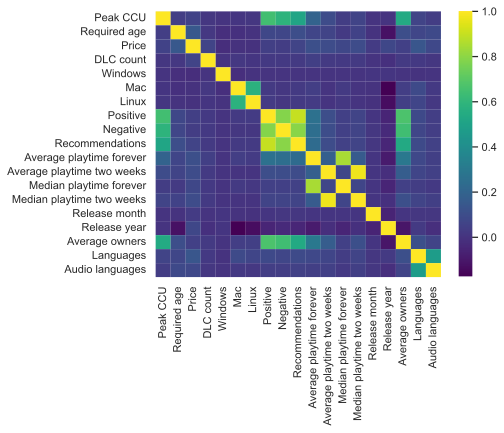

In [9]:
corr = df[df.columns[:19]].corr()
fig, ax = plt.subplots(1, 1)
sns.heatmap(corr, ax=ax, cmap="viridis")
ax.grid(False)

## Not very cool graphs

In [6]:
# columns = ["Release date", "Peak CCU", "Average playtime forever", "Median playtime forever"]
# fig, ax = plt.subplots(1, 4, figsize=(14.0, 4.0))
# fig.tight_layout()

# for i, column in enumerate(columns):
#     axi = ax[i]
#     sns.histplot(df[column], ax=axi, color=f"C{i}")
#     axi.set_xlabel(column)
#     axi.set_ylabel("Number of games")
# ax[0].tick_params(axis="x", rotation=60)

In [7]:
# columns = ["Release date", "Peak CCU", "Average playtime forever", "Median playtime forever"]
# fig, ax = plt.subplots(1, 4, figsize=(14.0, 4.0))
# plt.tight_layout()

# ax[0].plot_date(df[columns[0]], df["Price"])
# ax[0].set_xlabel(f"{columns[0]}")
# ax[0].set_ylabel("Price")
# ax[0].tick_params(axis="x", rotation=60)

# for i, column in enumerate(columns[1:]):
#     axi = ax[i + 1]
#     axi.scatter(df[column], df["Price"], color=f"C{i + 1}")
#     axi.set_xlabel(f"{column}")
#     axi.set_ylabel("Price")

# Classic regression algorithms

In [43]:
from sklearn import linear_model, model_selection, metrics

df = pd.read_csv("data/games.csv")
df = process_publishers(preprocess_df(df))
train_set, test_set = model_selection.train_test_split(df, train_size=0.8, random_state=42)
train_set = (train_set.drop(columns=["Price"]), train_set["Price"])
test_set = (test_set.drop(columns=["Price"]), test_set["Price"])

models = [
    linear_model.LinearRegression(),
    linear_model.Ridge(alpha=10),
]

for model in models:
    model.fit(train_set[0], train_set[1])

In [50]:
for model in models:
    preds = model.predict(test_set[0])
    mae = metrics.mean_absolute_error(test_set[1], preds)
    print(f"{model.__class__.__name__}: {mae:.2f}")

print(f"AlwaysPredict0€: {metrics.mean_absolute_error(test_set[1],       np.zeros_like(preds)):.2f}")
print(f"AlwaysPredict1€: {metrics.mean_absolute_error(test_set[1],       np.ones_like(preds)):.2f}")
print(f"AlwaysPredict5€: {metrics.mean_absolute_error(test_set[1], 5.0 * np.ones_like(preds)):.2f}")
print(f"AlwaysPredict7€: {metrics.mean_absolute_error(test_set[1], 7.0 * np.ones_like(preds)):.2f}")

LinearRegression: 5.34
Ridge: 5.33
AlwaysPredict0€: 7.85
AlwaysPredict1€: 7.10
AlwaysPredict5€: 5.82
AlwaysPredict7€: 6.09


# ANNs

In [49]:
class SteamGames(data.Dataset):
    def __init__(self, root, transform=None, target_transform=None, scale_prices=False):
        df = pd.read_csv(os.path.join(root, "games.csv"))
        df = convert_to_learning(preprocess_df(df))
        # df = process_publishers(preprocess_df(df))
        
        self.data_scaler = preprocessing.StandardScaler()
        self.price_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

        self.data = df.drop(columns=["Price"])
        self.label = df[["Price"]]

        self.data = self.data_scaler.fit_transform(self.data)
        if scale_prices:
            self.label = self.price_scaler.fit_transform(self.label)
        else:
            self.label = self.label.to_numpy()

        self.data = torch.from_numpy(self.data).float()
        self.label = torch.from_numpy(self.label).reshape(-1, 1).float()
        
        self.transform = transform
        self.target_transform = target_transform
        self.scale_prices = scale_prices

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        data, label = self.data[idx], self.label[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

    def denormalize_price(self, price):
        if self.scale_prices:
            return self.price_scaler.inverse_transform(price)
        else:
            return price

In [36]:
class Gamer(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size=1, dropout=0.5, lr=0.001):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size, output_size),
        )

        self.save_hyperparameters()

        self.lr = lr
        self.criterion = nn.MSELoss()

        self.validation_metrics = torchmetrics.MetricCollection([
            MeanSquaredError(),
            MeanAbsoluteError(),
        ], prefix="validation_")

        self.test_metrics = torchmetrics.MetricCollection([
            MeanSquaredError(),
            MeanAbsoluteError(),
        ], prefix="test_")

        self.example_input_array = torch.zeros((1, input_size), dtype=torch.float32)

    def forward(self, x):
        return self.layers(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, i):
        x, y = batch
        yhat = self.layers(x)
        
        loss = self.criterion(yhat, y)
        self.log("train_Loss", loss)

        return loss

    def validation_step(self, batch, i):
        x, y = batch
        yhat = self.layers(x)

        self.validation_metrics.update(yhat, y)
        self.log_dict(self.validation_metrics, on_step=False, on_epoch=True)

    def test_step(self, batch, i):
        x, y = batch
        yhat = self.layers(x)

        self.test_metrics.update(yhat, y)
        self.log_dict(self.test_metrics, on_step=False, on_epoch=True)

In [34]:
def train(model_class, train_loader, val_loader, **kwargs):
    trainer = pl.Trainer(
        default_root_dir = "logs",
        accelerator = "gpu" if str(device).startswith("cuda") else "cpu",
        devices = 1,
        max_epochs = 60,
        callbacks = [
            LearningRateMonitor(),
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="validation_MeanSquaredError"),
            ModelSummary(max_depth=-1),
        ],
        enable_progress_bar = True
    )
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None

    input_size = next(iter(train_loader))[0].shape[1]

    model = model_class(input_size=input_size, output_size=1, **kwargs)
    trainer.fit(model, train_loader, val_loader)
    model = model_class.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

def test(model, loader):
    trainer = pl.Trainer(
        default_root_dir = "logs",
        accelerator = "gpu" if str(device).startswith("cuda") else "cpu",
        devices = 1,
        max_epochs = 50,
        enable_progress_bar = True
    )
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None

    trainer.test(model, loader)

In [51]:
full_set = SteamGames(root="data/", scale_prices=False)
# train_set, val_set, test_set = data.random_split(full_set, [14705, 4902, 4901])
train_set, val_set, test_set = data.random_split(full_set, [37695, 12565, 12565])

In [52]:
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)
val_loader = data.DataLoader(train_set, batch_size=32, shuffle=False, num_workers=4)
test_loader = data.DataLoader(train_set, batch_size=32, shuffle=False, num_workers=4)

In [53]:
model = train(Gamer, train_loader, val_loader, hidden_size=2048)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                                 | Type              | Params | In sizes  | Out sizes
----------------------------------------------------------------------------------------------------
0  | layers                               | Sequential        | 4.4 M  | [1, 91]   | [1, 1]   
1  | layers.0                             | Linear            | 188 K  | [1, 91]   | [1, 2048]
2  | layers.1                             | ReLU              | 0      | [1, 2048] | [1, 2048]
3  | layers.2                             | Dropout           | 0      | [1, 2048] | [1, 2048]
4  | layers.3                             | Linear  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


In [54]:
test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 test_MeanAbsoluteError      4.844690322875977
  test_MeanSquaredError      62.8529167175293
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [54]:
model = Gamer.load_from_checkpoint("logs/lightning_logs/version_12/checkpoints/epoch=3-step=2356.ckpt").to(device)

In [55]:
model = model.to(device)
model.eval()
with torch.no_grad():
    all_preds = torch.empty((0,)).to(device)
    all_truth = torch.empty((0,)).to(device)
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        yhat = model(x)
    
        all_preds = torch.concat((all_preds, yhat))
        all_truth = torch.concat((all_truth, y))

all_preds = all_preds.cpu().numpy()
all_truth = all_truth.cpu().numpy()

all_preds = full_set.denormalize_price(all_preds)
all_truth = full_set.denormalize_price(all_truth)

print(f"MAE: {metrics.mean_absolute_error(all_truth, all_preds)}")
print(f"Min/max: {all_preds.min(), all_preds.max()}")

MAE: 4.844688892364502
Min/max: (-1.021319, 110.90055)


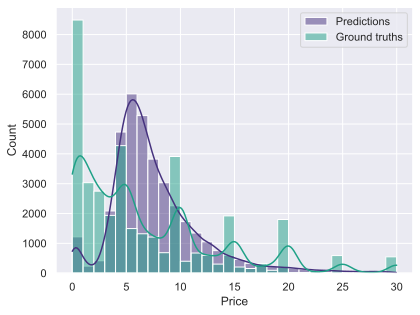

In [56]:
fig, ax = plt.subplots(1, 1)

sns.histplot(all_preds[((all_preds >= 0) & (all_preds < 30))], bins=30, ax=ax, kde=True, color="C0", label="Predictions")
sns.histplot(all_truth[((all_truth >= 0) & (all_truth < 30))], bins=30, ax=ax, kde=True, color="C9", label="Ground truths")
ax.legend()
ax.grid(True)
ax.set_xlabel("Price")
plt.show()